## Public : 210774.21916
## Private : 194684.93367

### 회고록
- 히트맵도 그려보고 로그 스케일링 적용 피처 개수도 늘려봤는데,
기존 베이스라인에서 오히려 성능이 더 하락함. 오차도 더 작았는데 점수는 20만대가 나왔음. (??)
- 결국 그냥 베이스라인에 IQR 적용하고 피처 엔지니어링 후에 LGBM 사용했음.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = os.path.join(os.getenv('HOME'), 'work/kaggle_kakr_housing/data')
# hint : os.getenv를 사용하거나 직접 경로를 작성

train_data_path = os.path.join(data_dir, 'train.csv')
sub_data_path = os.path.join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/home/jovyan/work/kaggle_kakr_housing/data/train.csv
/home/jovyan/work/kaggle_kakr_housing/data/test.csv


### 각 컬럼들이 의미하는 내용

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트

### 데이터셋 크기

- train 데이터셋의 총 컬럼 개수는 21개
- train 데이터셋은 타깃 피처 제외하고 총 컬럼 개수 20개

In [3]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print(f'train data dim : {data.shape}')
print(f'sub data dim : {sub.shape}') # 테스트 데이터는 당연히 price 컬럼이 없으므로 컬럼 개수가 1개 더 적음

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [4]:
y = data['price']
del data['price']

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [5]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))

21503


In [6]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 데이터 전처리 


### train / test 데이터셋 합치기
- train 데이터셋과 test 데이터셋을 합쳐서 전처리
- 이를 통해 train / test 데이터셋에 대해 동일하게 전처리 가능

원래는 train 데이터셋 먼저 전처리하고 전처리 방식이 옳다고 판단되면
test 데이터셋에 적용하는 방식으로 진행했었는데, 새로운 인사이트를 얻었다!


### 결측치 확인하기
- missingno 라이브러리의 matrix 함수 사용
- 데이터의 결측 상태 시각화 진행
- 데이터셋 내 결측치는 없는 것으로 나타남


### 학습을 위해 데이터셋 변수 정리하기
- id는 집값 예측과 전혀 관련이 없으므로 제거
- date 는 '연월일시간'으로 되어 있으므로 연월만 남기기 + 수치형 변수로 변경

<Axes: >

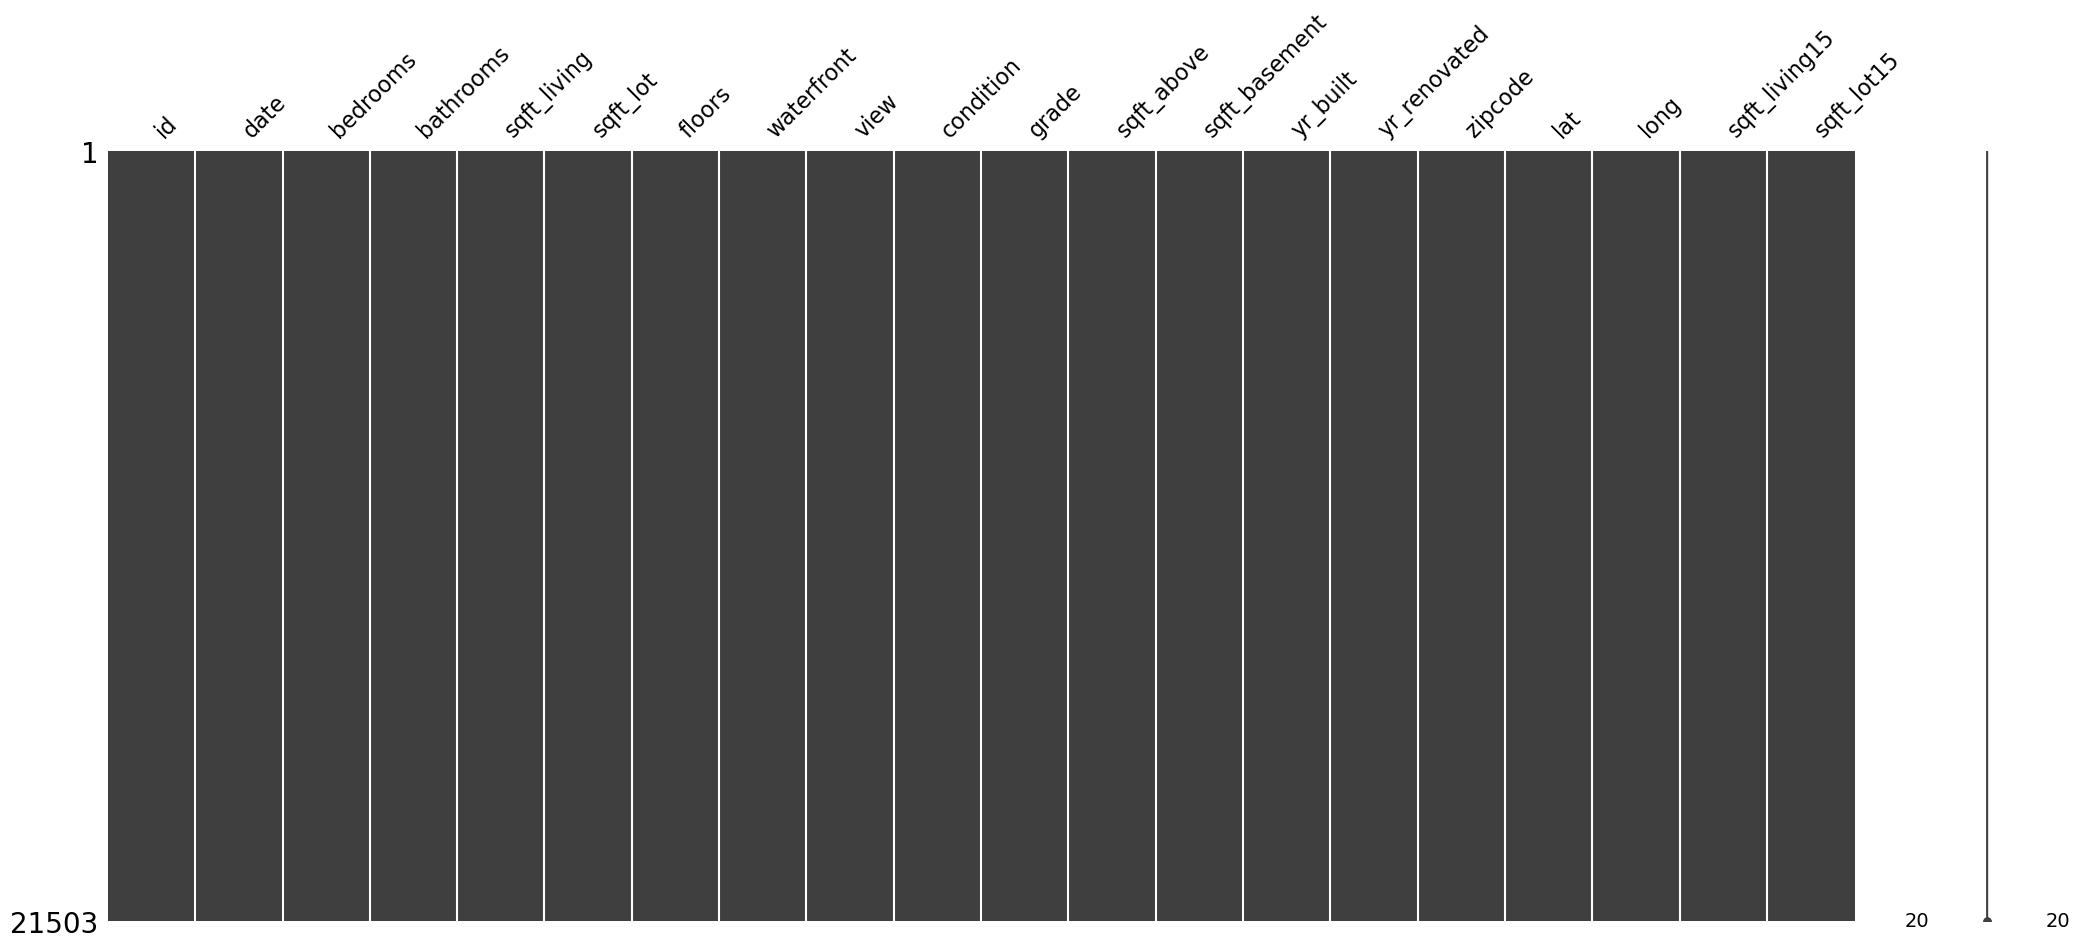

In [7]:
msno.matrix(data)

In [8]:
# 1. id 컬럼이 결측치인지 확인합니다.
null_check = pd.isnull(data['id'])
print(null_check)

0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Name: id, Length: 21503, dtype: bool


In [9]:
# 2. 결측치인 데이터만 뽑아냅니다.
null_data = data.loc[null_check, 'id']
null_data.head()

Series([], Name: id, dtype: int64)

In [10]:
# 3. 결측치인 데이터의 개수를 셉니다.
print(f'id: {len(null_data.values)}')

id: 0


In [11]:
# 한번에 정리해서 null 값 확인한 코드
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [12]:
sub_id = data['id'][train_len:]
del data['id']
data['date'] = data['date'].apply(lambda x : x[:6]).astype(int)

In [13]:
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [14]:
# Feature Engineering
def feature_engineering(df):
    # 날짜 자동 포맷 인식
    df['date'] = pd.to_datetime(df['date'], errors='coerce')  # 자동 인식, 실패 시 NaT
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['dayofweek'] = df['date'].dt.dayofweek

    # 리모델링 여부
    df['is_renovated'] = df['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)

    # 건물 나이
    df['age_when_sold'] = df['year'] - df['yr_built']

    # 방당 욕실 수
    df['bath_per_bed'] = df['bathrooms'] / (df['bedrooms'] + 1e-5)

    # 공간당 면적
    df['living_per_room'] = df['sqft_living'] / (df['bedrooms'] + df['bathrooms'] + 1e-5)

    return df

data = feature_engineering(data)
data = data.drop(columns=['date'])

### 각 변수들의 분포 확인
- 치우친 분포들이 있을 수 있으므로 각 변수들의 분포 확인하기
- bedrooms, bathrooms, sqft_living, sqft_lot, waterfront, view 등이 치우침

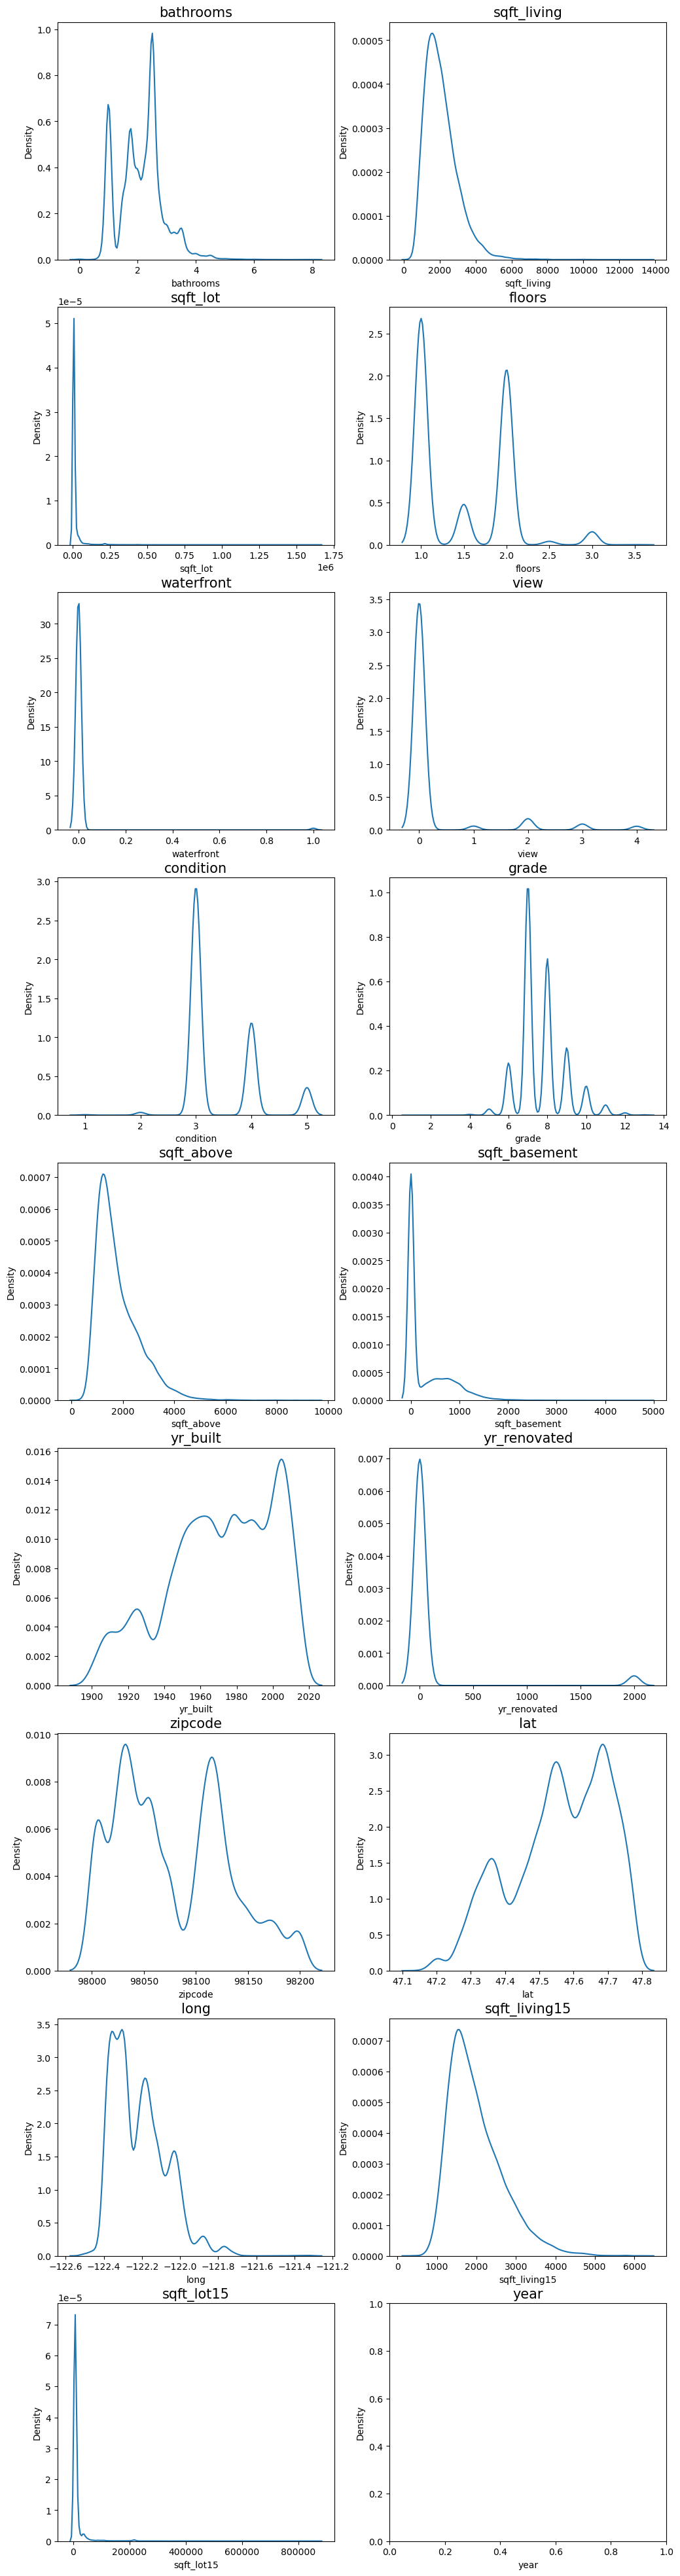

In [15]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요.

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [16]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

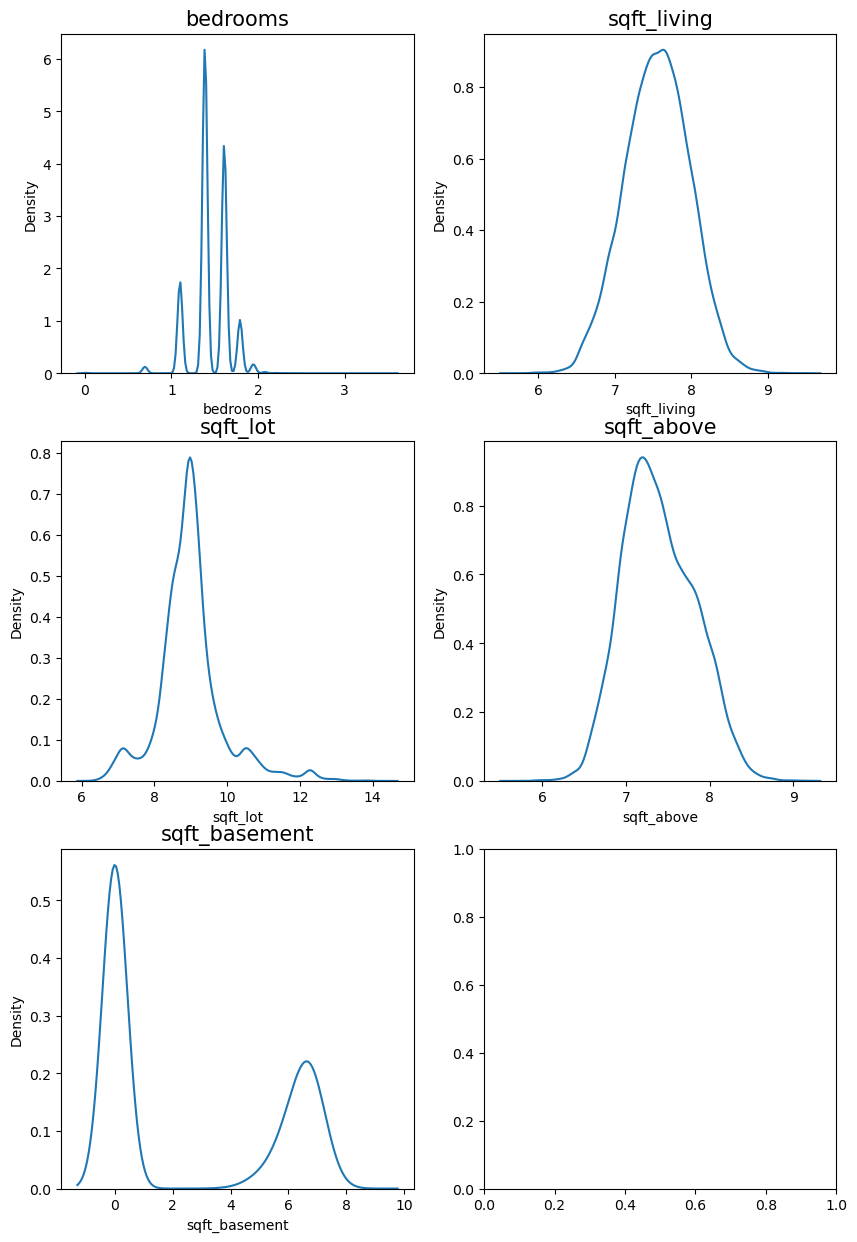

In [17]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1



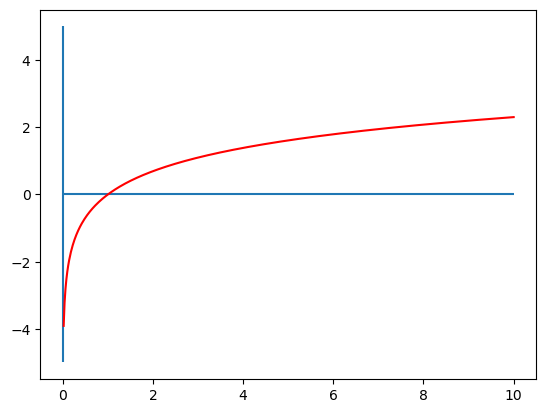

In [18]:
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

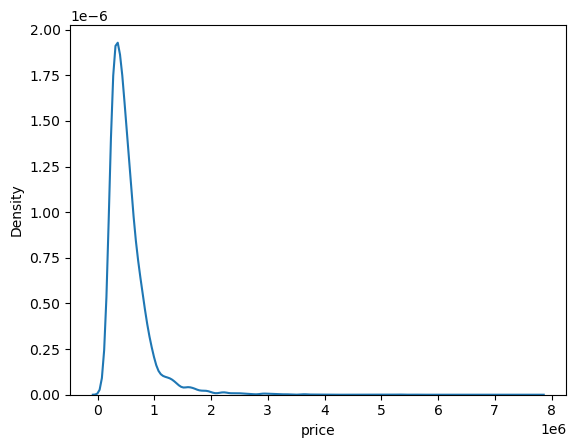

In [19]:
sns.kdeplot(y)
plt.show()

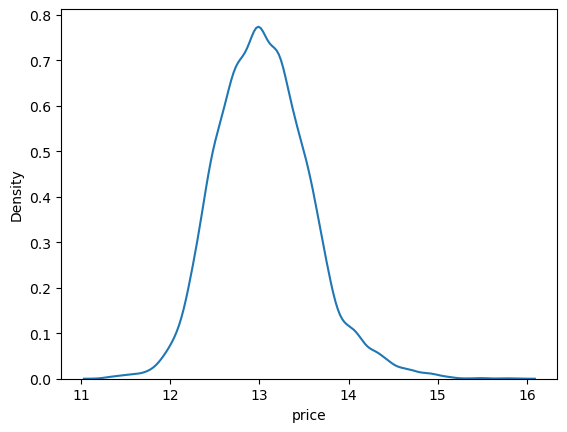

In [20]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

In [21]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 25)
(6468, 25)


In [22]:
# x에 train 데이터만 복사
x = data[:train_len].copy()

# 수치형 컬럼에서 이상치 제거 (IQR)
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        cond = (df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)
        df = df[cond]
    return df

# 수치형 컬럼만 선택
numeric_cols = x.select_dtypes(include=['float64', 'int64']).columns.tolist()

# 이상치 제거 적용
x = remove_outliers_iqr(x, numeric_cols)

# 기존 y도 x에 맞춰 인덱스 슬라이싱
y = y.loc[x.index]

# 확인
print("x shape:", x.shape)
print("y shape:", y.shape)

x shape: (9417, 25)
y shape: (9417,)


## 3. 모델링

### Average Blending
- 여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들기

In [23]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### Cross Validation
- 교차 검증을 통해 모델의 성능을 평가

In [24]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

In [25]:
## 아래 코드를 실행하기 위해서는 scikit-learn 버전을 1.6.1에서 1.5.2로 다운그레이드를 해야함
## 하고 나서 런타임 재시작 필수!!

!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
  Using cached scikit_learn-1.5.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.9 MB)


In [26]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8336
Model: XGBoost, CV score:0.8509
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2521
[LightGBM] [Info] Number of data points in the train set: 7533, number of used features: 18
[LightGBM] [Info] Start training from score 440733.373025
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2521
[LightGBM] [Info] Number of data points in the train set: 7533, number of used features: 18
[LightGBM] [Info] Start training from score 440021.930174
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000294 seconds.
You

In [27]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [28]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2530
[LightGBM] [Info] Number of data points in the train set: 9417, number of used features: 18
[LightGBM] [Info] Start training from score 439179.553361
6468


array([497169.9301133 , 482649.26308145, 787705.16946111, ...,
       474043.99559888, 348133.40093198, 450224.77984832], shape=(6468,))

In [29]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

# 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 50],
    'boosting_type': ['gbdt', 'dart']
}

# 모델 정의
lgb_model = LGBMRegressor(random_state=42)

# GridSearchCV 설정
grid_search = GridSearchCV(estimator=lgb_model,
                           param_grid=param_grid,
                           cv=3,
                           scoring='neg_root_mean_squared_error',
                           verbose=1,
                           n_jobs=-1)

# x, y는 기존 학습 데이터셋 변수명
grid_search.fit(x, y)

# 최적 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(sub)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2515
[LightGBM] [Info] Number of data points in the train set: 6278, number of used features: 18
[LightGBM] [Info] Start training from score 441339.939630
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

## 4. submission 제출하기

In [30]:
data_dir = './data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [31]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [32]:
sub.to_csv('submission.csv', index=False)